# Part 2: Dynamical spin structure factor

## Part a

In [2]:
import a_mps_Gio, b_model_Gio, c_tebd_Gio
import numpy as np
from scipy.linalg import svd
import importlib 
import matplotlib.pyplot as plt
#from tqdm import tqdm


In [3]:
importlib.reload(a_mps_Gio)
importlib.reload(b_model_Gio)
importlib.reload(c_tebd_Gio)

<module 'c_tebd_Gio' from '/home/t30/pol/go56vod/Desktop/Fopra32/c_tebd_Gio.py'>

In [4]:
sigmay = np.array([[0,-1j],[1j,0]])
sigmax = np.array([[0,1],[1,0]])


## Right code!

In [5]:
def find_psi(L, J, g):   
    E0, psi, model = c_tebd_Gio.example_TEBD_gs_finite(L,J,g)
    return E0, psi, model

In [6]:
def correlation_Ctj(E0, psi, model, L, X, Y, T = 50, dt = 0.01): #model - Hamiltonian, psi - class of wave function, T - last time step 
    psi1 = psi.copy() #take a copy of psi which is ground state
    S = []
    i = L//2 # i= L//2 index of Y
    tensor1 = np.tensordot(psi.Bs[i], Y, [1,1]) # vL [i] vR, i [i*] -> vL vR i
    psi.Bs[i] = tensor1.transpose([0,2,1])
    U_bond = c_tebd_Gio.calc_U_bonds_real(model, dt)
    corr = []
    N = int(T//dt)
    
    for r in range(N):

        exp_factor = np.exp(1j*E0*r*dt)
        if r != 0:
            c_tebd_Gio.run_TEBD(psi, U_bond, N_steps=1, chi_max=100, eps=1.e-10) #found new psi by applying e^-iHdt
        S.append(psi.entanglement_entropy())
        tensor1 = [np.array([[1]])] #this first element is a dummy matrix of dimension 1x1, i.e. a number written as a matrix
        #we do this because then we have to contract this element with the final tensorC, which is also is a number with dummy indeces!
        tensor1.append(np.tensordot(psi.Bs[L-1], psi1.Bs[L-1].conj(), [[1,2],[1,2]])) # vL [i] [vR] , vL* [i*] [vR*] -> vL vL*
        #indeces of Bs go from 0 to L-1
        #for j in range(10) goes from 0 to 9 
        #for j in range (9,0,-1) goes from 9 to 1
        for j in range(L-2,0,-1):
            tensor2 = np.tensordot(psi.Bs[j],tensor1[-1], [2,0]) # vL i [vR] ,[vL] vL* -> vL i vL*
            tensor1.append(np.tensordot(tensor2, psi1.Bs[j].conj(), [[1,2],[1,2]])) # vL [i] [vL*], vL* [i*] [vR*] ->  vL vL*
            #tensor2 = np.tensordot(psi1.Bs[j], psi.Bs[j].conj(), [1,1])  vL [i] vR , vL* [i*] vR* -> vL vR vL* vR*
            #tensor1.append(np.tensordot(tensor2,tensor1[k],[[1,3],[0,1]])) # vL [vR] vL* [vR*], [vL] [vL*] -> vL vL*
        # print(len(tensor1)) 
        # tensor1 should have L elements
        corr.append([])
        tensorA = np.tensordot(psi.Bs[0], psi1.Bs[0].conj(),[[0,1],[0,1]]) # [vL] [i] vR , [vL*] [i*] vR* -> vR vR*
        tensorB = np.tensordot(psi.Bs[0], X, [1,1]) # vL [i] vR , i [i*] -> vL vR i
        tensorC = np.tensordot(tensorB,psi1.Bs[0].conj(), [[0,2],[0,1]]) # [vL] vR [i], [vL*] [i*] vR* -> vR vR*
        corr[r].append(np.tensordot(tensorC,tensor1[-1], [[0,1],[0,1]])) # [vR] [vR*], [vL] [vL*]

        for j in range(1,L):
            tensorB = np.tensordot(psi.Bs[j], X, [1,1]) # vL [i] vR , i [i*] -> vL vR i
            tensorbeforeC = np.tensordot(tensorA, tensorB, [0,0]) # [vR] vR*, [vL] vR i -> vR* vR i
            tensorC = np.tensordot(tensorbeforeC,psi1.Bs[j].conj(), [[0,2],[0,1]]) # [vR*] vR [i], [vL*] [i*] vR* -> vR vR*
            #print(tensorC.shape, j)
            #print(tensor1[L-j-2].shape) #- mettili se c'è sum mismatch prima di un certo tensorproduct
            corr[r].append(np.tensordot(tensorC,tensor1[L-j-1], [[0,1],[0,1]])) # [vR] [vR*], [vL] [vL*]
            #tensorintermediate = np.tensordot(psi1.Bs[j], psi.Bs[j].conj(),[1,1]) # vL [i] vR , vL* [i*] vR* -> vL vR vL* vR*
            #tensorloop = np.tensordot(tensorA, tensorintermediate, [[0,1],[0,2]]) # [vR] [vR*], [vL] vR [vL*] vR* -> vR vR*
            tensorintermediate = np.tensordot(tensorA, psi.Bs[j], [0,0]) # [vR] vR*, [vL] i vR -> vR* i vR
            tensorloop = np.tensordot(tensorintermediate, psi1.Bs[j].conj(), [[0,1],[0,1]]) # [vR*] [i] vR, [vL*] [i*] vR* -> vR vR*
            tensorA = tensorloop

        corr[r] = np.array(corr[r])* exp_factor

    return S, corr

### Calculate entropy and correlation C(t,j)

In [26]:
L = 20
J = 1
g = 0.2
T = 10
dt = 0.1

In [27]:
E0, psi, model = find_psi(L, J, g)

finite TEBD, (imaginary time evolution)
L=20, J=1.0, g=0.20
dt = 0.10000: E = -19.2205282640590
dt = 0.01000: E = -19.2205986421454
dt = 0.00100: E = -19.2206058029562
dt = 0.00010: E = -19.2206065208652
dt = 0.00001: E = -19.2206065926539
final bond dimensions:  [2, 4, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 4, 2]


In [28]:
Entropy, Correlation = correlation_Ctj(E0, psi, model, L, sigmay, sigmay, T, dt)

Plot of Entanglement Entropy

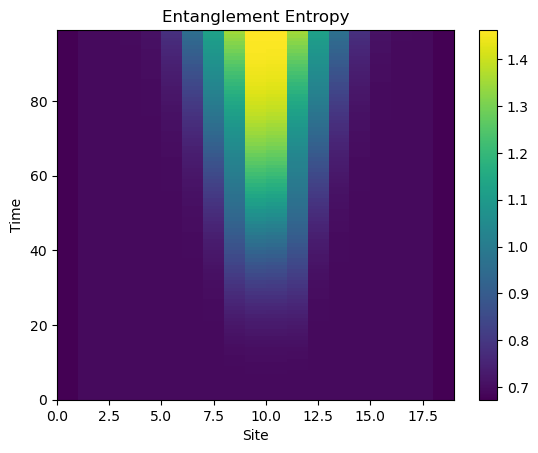

In [29]:
#plt.imshow
#plt.pcolormesh
#plt.plot()
#T = np.arange(1,201,1)
#print(T)
#Hey = [T,S]
plt.pcolormesh(Entropy, cmap = 'viridis')
plt.xlabel('Site')
plt.ylabel('Time')
plt.title('Entanglement Entropy')
plt.colorbar()

Plot of Correlation Function

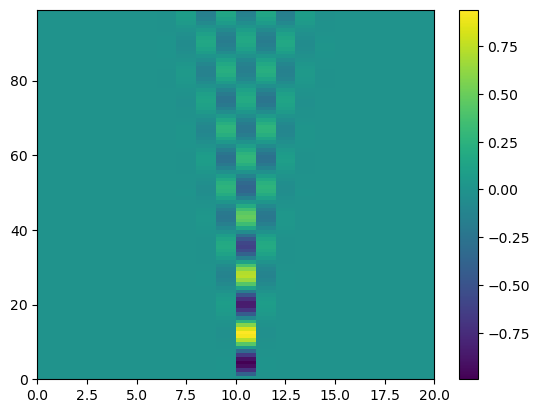

In [30]:
plt.pcolormesh(np.imag(Correlation), cmap = 'viridis')
plt.colorbar()

In [31]:
Correlation = np.array(Correlation)
print(Correlation.shape)
#print(Correlation.shape())

(99, 20)


## Part b 

- Write another function that performs a Fourier transformation in space and time to obtain the dynamic structure factor $S(k, \omega)$:

$$
S(k, \omega) = \sum^{L−1}_{j=0} \sum^N_{t_n = 0}e^{i\omega \delta t \cdot t_n − i k \cdot j} C(\Delta t \cdot t_n, j) · G(tn)
$$


- Remember to multiply the signal with a Gaussian window function G(tn) in order to avoid Gibbs oscillations from the Fourier transform of the finite time data (cf. equation (7)).

Now we have found C(t,j)= C_t,j which is a matrix (list) with each row corresponding to a specific time step where correlation function is evaluated for each site j (for sigmay_j) 

In [32]:
import FourierTransform as FT
importlib.reload(FT)

<module 'FourierTransform' from '/home/t30/pol/go56vod/Desktop/Fopra32/FourierTransform.py'>

Compute Fourier transform
finished
49
(21,)
21


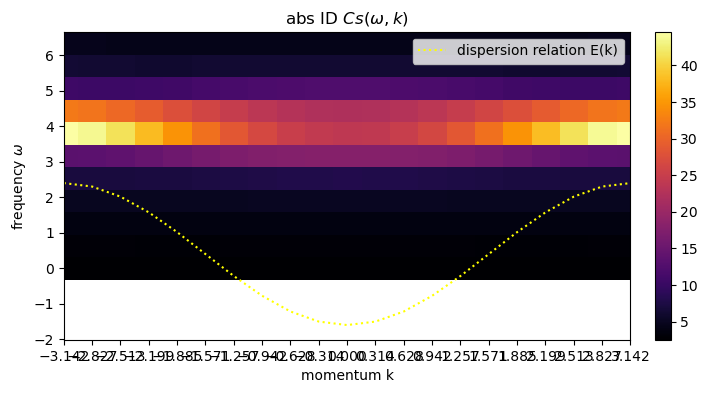

In [33]:
Swk, momenta, freqs = FT.get_Swk(Correlation, L, dt = 0.1)
FT.plot_Swk(Swk, momenta, freqs, g, J, interval = 10)

In [157]:
def get_spectral_function(corrs, L, dt):
        
    # Rearrange corrs such that position 0 corresponds to the perturbed site
    # (distance 0 to perturbation)
    print(corrs.shape)
    xi = L//2
    c_temp = np.zeros(corrs.shape, dtype=complex)
    c_temp[:, :L-xi] = corrs[:, xi:]
    c_temp[:, L-xi:] = corrs[:, :xi]
    corrs = c_temp
    
    print('Compute Fourier transform')
    # Fourier transform in space
    corrs_tk = np.zeros((corrs.shape[0], corrs.shape[1]+1), dtype=complex)
    for i in np.arange(corrs.shape[0]):
        momenta, Ck = fourier_space(corrs[i,:])
        corrs_tk[i, :] = Ck
        
    # Fourier transform in time
    Swk = np.zeros(corrs_tk.shape, dtype=complex)
    for k in np.arange(corrs_tk.shape[1]):
        freqs, Sw = fourier_time(corrs_tk[:, k], dt)
        Swk[:, k] = Sw
    print('finished')
    
    return np.array(Swk), momenta, freqs


def fourier_time(t_series, dt, sigma = 0.4):
    """ Calculates the FFT of a time series, applying a Gaussian window function. """
    
    # Gaussian window function
    n = len(t_series)
    gauss = [np.exp(-1/2.*(i/(sigma * n))**2) for i in np.arange(n)]
    input_series = gauss * t_series
    
    # Fourier transform
    ft = np.fft.fft(input_series)
    freqs = np.fft.fftfreq(n, dt) * 2 * np.pi
    
    # order frequencies in increasing order
    end = np.argmin(freqs)
    freqs = np.append(freqs[end:], freqs[:end])
    # shift results accordingly
    ftShifted = np.append(ft[end:], ft[:end])
    
    # Take into account the additional minus sign in the time FT
    if len(ftShifted)%2 == 0:
        ftShifted = np.append(ftShifted, ftShifted[0])
        ftShifted = ftShifted[::-1]
        ftShifted = ftShifted[:-1]
    else:
        ftShifted = ftShifted[::-1]
        
    return freqs, ftShifted


def fourier_space(x_series):
    """ Calculates the FFT of a spatial series of values. """
    import numpy as np
    ft = np.fft.fft(x_series)
    n = len(x_series)
    momenta = 2*np.pi * np.fft.fftfreq(n, 1)
    
    # order momenta in increasing order
    momenta = np.fft.fftshift(momenta)
    
    # shift results accordingly
    Ck = np.fft.fftshift(ft)
    
    # extend the results to the whole Brillouin zone (right border included)
    momenta = np.append(momenta, -momenta[0])
    Ck = np.append(Ck, Ck[0])
    
    return momenta, Ck

In [ ]:
print(L)
Swk, momenta, freqs = get_spectral_function(np.array(test_corr), 20, 0.1)

30
(50, 20)
Compute Fourier transform
finished


# Part c

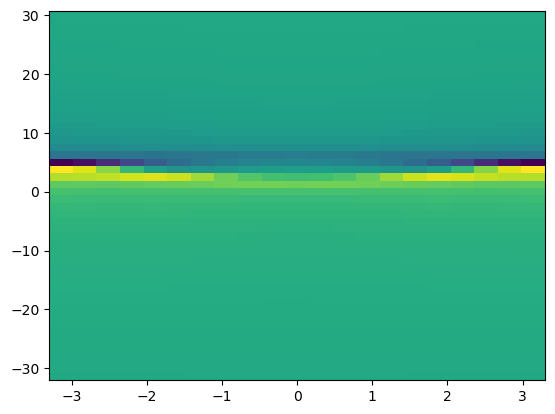

In [ ]:
plt.figure()
plt.pcolormesh(momenta, freqs, np.real(Swk[]))

In [196]:
systemsize30 = correlation_Ctj(20, J , 0.2, sigmay,sigmay, 20, 0.1)

finite TEBD, (imaginary time evolution)
L=20, J=1.0, g=0.20


dt = 0.10000: E = -19.2205282640590
dt = 0.01000: E = -19.2205986421454
dt = 0.00100: E = -19.2206058029562
dt = 0.00010: E = -19.2206065208652
dt = 0.00001: E = -19.2206065926539
final bond dimensions:  [2, 4, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 4, 2]


In [197]:
print(systemsize30[0])

[array([0.67322409, 0.69240765, 0.69321141, 0.69321897, 0.69324296,
       0.69322027, 0.69324301, 0.69322028, 0.69324301, 0.69325619,
       0.69325506, 0.69322163, 0.69324301, 0.69322027, 0.69324296,
       0.69321897, 0.69321141, 0.69240765, 0.67322409]), array([0.67323146, 0.69238377, 0.69322274, 0.69320958, 0.69325373,
       0.69321091, 0.69325378, 0.69321091, 0.69325692, 0.69333138,
       0.69333008, 0.69322469, 0.69325378, 0.69321091, 0.69325373,
       0.69320958, 0.69322274, 0.69238377, 0.67323146]), array([0.67323728, 0.69236483, 0.69323098, 0.69320413, 0.6932615 ,
       0.69320547, 0.69326155, 0.69320549, 0.69328332, 0.69346666,
       0.69346511, 0.69326314, 0.69326156, 0.69320547, 0.6932615 ,
       0.69320413, 0.69323098, 0.69236483, 0.67323728]), array([0.67324073, 0.69235238, 0.69323491, 0.69320357, 0.69326507,
       0.69320493, 0.69326512, 0.69320501, 0.69334221, 0.69367824,
       0.69367648, 0.69336471, 0.69326521, 0.69320493, 0.69326507,
       0.69320357, 0.693

Plot correlazione

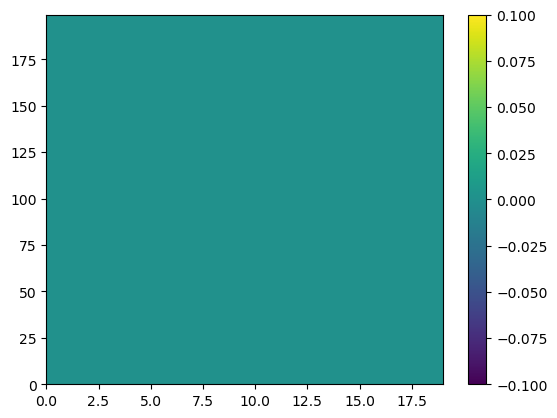

In [200]:
plt.pcolormesh(np.imag(systemsize30[0]), cmap = 'viridis')
plt.colorbar()

Plot 

In [ ]:
Swk1, momenta1, freqs1 = get_spectral_function(np.array(test_corr), 20, 0.1)

PUNTO PRINCIPALE del colloquium: capire la fisica di quello che si sta vedendo!